## Extracting Monthly Temperature Data from Array

### Author: Ryan Gan
### Date: 2018-05-28

Extracting gridded temperature values to North American region. First attempt with Python.

In [52]:
# import dataset from netCDF as nc_open; array storage system
import netCDF4 as nc
from netCDF4 import Dataset as nc_open
# import numpy as np; for working with array data
import numpy as np
# import pandas as pd; working with data.frames
import pandas as pd
# Matplotlib for additional customization
from matplotlib import pyplot as plt 
%matplotlib inline
#import mpl_toolkits # i'd like basemap but doesn't seem to be available for py3
# Seaborn for plotting and styling
import seaborn as sns

Open connection to monthly temperature netCDF file.

In [5]:
temp_nc = nc_open("./data/air.mon.mean.nc")

Print out summary of temperature NetCDF file. It looks like x/lon = 144, y/lat = 73, and 843 months.

In [6]:
print(temp_nc)
# print out details of each variable
for v in temp_nc.variables:
    print(temp_nc.variables[v])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: Data from NCEP initialized reanalysis (4x/day).  These are the 0.9950 sigma level values
    platform: Model
    Conventions: COARDS
    NCO: 20121012
    history: Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc air.mon.mean.nc
Thu May  4 18:11:50 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc ./surface/air.mon.mean.nc
Mon Jul  5 23:47:18 1999: ncrcat ./air.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/surface/air.mon.mean.nc
/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Mon Oct 23 21:04:20 1995 from air.sfc.gauss.85.nc
created 95/03/13 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
    title: monthly mean air.sig995 from the NCEP Reanalysis
    References: http://www.esrl.noaa.gov/psd/dat

### Extracting Grid Locations of Temperature Grid

I'm going to see if I can output the grid locations and plot it.

In [7]:
# extract latitude
lat = temp_nc.variables['lat'][:]
# extract longitude
lon = temp_nc.variables['lon'][:]
# extract time
time = temp_nc.variables['time'][:]
# 1st temperature values
temp = temp_nc.variables['air'][1,:,:]
# check dimension of shape
np.shape(temp)

(73, 144)

Print out min, mean, max of temperature vector.

In [8]:
print(np.min(temp), np.mean(temp), np.max(temp))

-44.23103 2.1757680582310694 35.399654


Using Seaborn to print out a heatmap the first matrix of temperature. I notice the outline of the continents based on the temperature. You can see the Rocky mountains and the Andes mountains running down the left side of the Americas. The Poles are much colder. The Australian outback looks hot too.

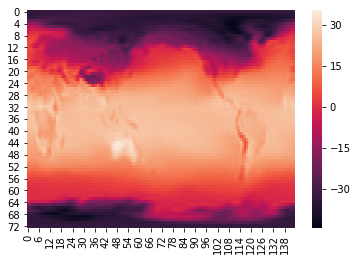

In [9]:
sns.heatmap(temp)

I want to subset the array to the spatial extent of the continental United States.  The longitude bounds should be  -124.848974 to -66.885444. I will need to add 180 degrees to these degrees west to match the convert from degrees east of the nc file. The latitude bounds should be 24.396308 to 49.384358.

In [10]:
# lat and lon bounds
latbounds = [24.4, 49.4]
# lon bounds need to be converted from easterling to westerling to get US
lonbounds = [-124.8 + 360, -66.9 + 360]

# latitude lower and upper bounds
lat_ui = np.argmin(np.abs(lat - latbounds[0]))
lat_li = np.argmin(np.abs(lat - latbounds[1]))

# longitude lower and upper boudns
lon_li = np.argmin(np.abs(lon - lonbounds[0]))
lon_ui = np.argmin(np.abs(lon - lonbounds[1]))
# print index
print(lat_li, lat_ui, lon_li, lon_ui)

16 26 94 117


Subset latitude and longitude grid points.

In [11]:
# subset us lon
lon_us = lon[lon_li:lon_ui]-360
# subset us lat
lat_us = lat[lat_li:lat_ui]
# print dimensions
print(np.min(lon_us), np.max(lon_us), np.min(lat_us), np.max(lat_us))

-125.0 -70.0 27.5 50.0


Print points over US.

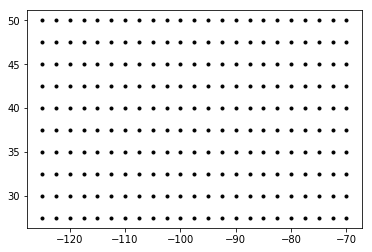

In [12]:
# extract lonlat grid
lons, lats = np.meshgrid(lon_us, lat_us)
# plot
plt.plot(lons, lats, marker='.', color='k', linestyle='none')
plt.show()

In [13]:
# subset temp to us
temp_us = temp_nc.variables['air'][1, lat_li:lat_ui, lon_li:lon_ui]
np.shape(temp_us)

(10, 23)

Plot heatmap of US temperature to make sure subset looks right.

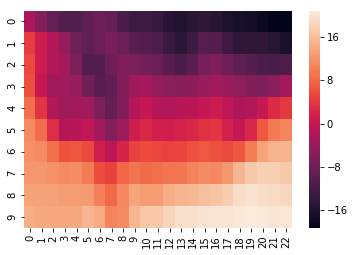

In [15]:
sns.heatmap(temp_us)

Attempt to extract lat-lon grid.

In [26]:
# coordinates to a 2 dimension array
us_grid = np.array(np.meshgrid(lon_us, lat_us)).reshape(2, 230).T
# check dimensions
np.shape(us_grid)

(230, 2)

In [65]:
# extract temp grid as a 230 by n matrix
us_temp = np.array(temp_nc.variables['air']
    [:, lat_li:lat_ui, lon_li:lon_ui]).reshape(843,230).T #.T is for transpose
np.shape(us_temp)

(230, 843)

Creating data frame of us temp and coordinates using pandas. I'm going to create a sequential numeric vector to indicate grid cell id.

In [114]:
# create grid id 1 to 230 and save as type string
grid_id = pd.DataFrame(data = np.arange(1, 231, 1).T).astype('str')
grid_id.columns = ['grid_id'] 
# head and tail
print(grid_id.head(), grid_id.tail())

  grid_id
0       1
1       2
2       3
3       4
4       5     grid_id
225     226
226     227
227     228
228     229
229     230


Binding/concatenating grid id variable with lon and lat coordinates.

In [116]:
# create grid dataframe from coordinate array
grid_df = pd.DataFrame(data = us_grid)
# name columns
grid_df.columns = ['lon', 'lat']
# concat dataframes
grid_df = pd.concat([grid_id, grid_df], axis=1)
# view first rows
grid_df.head()

,grid_id,lon,lat
0,1,-125.0,50.0
1,2,-122.5,50.0
2,3,-120.0,50.0
3,4,-117.5,50.0
4,5,-115.0,50.0


Assigning year and month as column header for temperature values.

In [117]:
from datetime import datetime
# extract date times from nc file; define units
date = nc.num2date(time, 'hours since 1800-01-01 00:00:0.0')
# ts
ts = pd.Series(date, index = date)
# view first couple observations
ts.head()

1948-01-01   1948-01-01
1948-02-01   1948-02-01
1948-03-01   1948-03-01
1948-04-01   1948-04-01
1948-05-01   1948-05-01
dtype: datetime64[ns]

Convert temperature array to dataframe.

In [118]:
# array to dataframe
temp_df = pd.DataFrame(data = us_temp)
# dim of temp dataframe
print(temp_df.shape)
# add name
temp_df.columns = ts.dt.date
temp_df.head()

(230, 843)


,1948-01-01,1948-02-01,1948-03-01,1948-04-01,1948-05-01,1948-06-01,1948-07-01,1948-08-01,1948-09-01,1948-10-01,...,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01
0,-0.177099,-2.077586,-0.239029,2.191003,7.611294,13.192339,12.858393,12.739360,9.911337,6.384842,...,10.256660,11.999190,14.542734,12.675834,7.008055,2.904991,0.984665,2.214507,-0.944651,1.861282
1,-4.285485,-6.013789,-3.848709,-0.130663,6.882905,13.428675,12.796779,12.160331,8.692340,4.326452,...,10.352497,13.210485,16.020155,11.941668,4.152406,-0.133345,-3.661304,-0.604847,-5.032155,-0.858074
2,-7.342901,-8.820339,-6.651283,-1.801997,5.973875,12.425673,12.284524,11.207426,8.276340,3.340968,...,10.314163,15.175801,17.268545,11.426662,2.589507,-2.077511,-6.795979,-2.487108,-7.716079,-2.565335
3,-9.044832,-10.528955,-8.717089,-2.501661,5.455161,11.236004,11.800975,10.851940,8.617005,3.287746,...,10.444163,16.929836,17.392738,10.997497,2.364503,-3.157513,-8.650819,-3.749209,-9.770546,-3.425822
4,-8.838060,-10.780340,-9.229991,-1.438334,6.389682,11.545676,12.848073,12.675164,10.066670,4.328714,...,11.933335,18.716932,17.437092,11.281663,3.429020,-3.200013,-9.183882,-4.375815,-11.399117,-3.526622


Bind temperature values to coordinate and grid id and then melt/gather columns to row.

In [119]:
# concat grid id and temp
temp_wide_df = pd.concat([grid_df, temp_df], axis = 1)
temp_wide_df.head()

,grid_id,lon,lat,1948-01-01,1948-02-01,1948-03-01,1948-04-01,1948-05-01,1948-06-01,1948-07-01,...,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01
0,1,-125.0,50.0,-0.177099,-2.077586,-0.239029,2.191003,7.611294,13.192339,12.858393,...,10.256660,11.999190,14.542734,12.675834,7.008055,2.904991,0.984665,2.214507,-0.944651,1.861282
1,2,-122.5,50.0,-4.285485,-6.013789,-3.848709,-0.130663,6.882905,13.428675,12.796779,...,10.352497,13.210485,16.020155,11.941668,4.152406,-0.133345,-3.661304,-0.604847,-5.032155,-0.858074
2,3,-120.0,50.0,-7.342901,-8.820339,-6.651283,-1.801997,5.973875,12.425673,12.284524,...,10.314163,15.175801,17.268545,11.426662,2.589507,-2.077511,-6.795979,-2.487108,-7.716079,-2.565335
3,4,-117.5,50.0,-9.044832,-10.528955,-8.717089,-2.501661,5.455161,11.236004,11.800975,...,10.444163,16.929836,17.392738,10.997497,2.364503,-3.157513,-8.650819,-3.749209,-9.770546,-3.425822
4,5,-115.0,50.0,-8.838060,-10.780340,-9.229991,-1.438334,6.389682,11.545676,12.848073,...,11.933335,18.716932,17.437092,11.281663,3.429020,-3.200013,-9.183882,-4.375815,-11.399117,-3.526622


In [121]:
# wide to long
temp_long_df = pd.melt(temp_wide_df, id_vars = ['grid_id', 'lon', 'lat'],
                      var_name = "date", value_name = "temp_c")
# view head of final row-wise dataset
temp_long_df.head()

,grid_id,lon,lat,date,temp_c
0,1,-125.0,50.0,1948-01-01,-0.177099
1,2,-122.5,50.0,1948-01-01,-4.285485
2,3,-120.0,50.0,1948-01-01,-7.342901
3,4,-117.5,50.0,1948-01-01,-9.044832
4,5,-115.0,50.0,1948-01-01,-8.838060
